### Part 1: data pre-processing

In [1]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing

#!pip3 install sklearn # Install machine learning library
import sklearn # For machine learning library
from sklearn.ensemble import RandomForestClassifier  # Random forest classifier
#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score

import matplotlib.pyplot as plt  #plotting library

##### 1.1 Eco Loss data

In [ ]:
fname='C:\\Users\\HP\\Desktop\\Hurricane\\damage.csv'

# Read EcoLoss data
Ecoloss = pd.read_csv(fname)
Ecoloss.head()

In [ ]:
# Extract month from landfall date
Ecoloss['MONTH'] = Ecoloss['landfall date'].apply(lambda x: str(x)[0:3])

# Extract date from landfall date
Ecoloss['DATE'] = Ecoloss['landfall date'].apply(lambda x: str(x)[4:6])

# Extract year from landfall date
Ecoloss['YEAR'] = Ecoloss['landfall date'].apply(lambda x: str(x)[7:11])

Ecoloss.head()

In [ ]:
Month2Int={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
Ecoloss['MONTHINT']=Ecoloss['MONTH'].apply(lambda x: Month2Int[x])
Ecoloss.head()

In [ ]:
Ecoloss=Ecoloss[(Ecoloss['YEAR']>='1982') & (Ecoloss['YEAR']<='2017')]
Ecoloss.head()

In [ ]:
Ecoloss.YEAR.value_counts().sort_index()

In [ ]:
Ecoloss=Ecoloss.reset_index(drop=True)

In [ ]:
# set a 'key' to match ships dataset
# upper Name[0:4]+Year+Month(int)
Ecoloss['KEY']=0
for i in range(0,Ecoloss.shape[0]):
    Ecoloss.loc[i,'KEY']='-'.join([Ecoloss.loc[i,'storm name'][0:4].upper(),Ecoloss.loc[i,'YEAR'],Ecoloss.loc[i,'MONTHINT']])
Ecoloss.head()

In [ ]:
Ecoloss.shape[0]

##### 1.2 Ships data

In [ ]:
#====================================
#Read SHIPS spread-sheet data
#====================================
# Set up the location of the SHIPS data
fname='C:\\Users\\HP\\Desktop\\SHIPS_RII_fcst_ATL_Alicia_from1982 - copy.csv'
#fname='Dataset_SHIPS_RII_EPAC.csv'

# Read SHIPS data
ships = pd.read_csv(fname)
ships.head()

In [ ]:
#================================
# Set up parameters
#================================
# Year range for training and validating
#year_train=['1998','2008']

# Year range for forecast
#year_fcst=['2009','2014']

# Variable names for predictors
#PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125   #ATL 30 kt
#clim=0.084   #EPAC 30 kt

In [ ]:
#================================
# Data pre-processing
#================================
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

# drop NaNs
ships=ships.dropna()

# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4])

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))

# Extract day from date
ships['DAY'] = ships['DATE'].apply(lambda x: str(x)[4:6])

# Set the target column
ships['TAR'] = ships[TargetName].apply(lambda x: 1 if x >= RIValue else 0)
ships.head()

In [ ]:
ships=ships.reset_index(drop=True)
# set a 'key' to match ships dataset
# upper Name[0:4]+Year+Month(int)
ships['KEY']=0
for i in range(0,ships.shape[0]):
    ships.loc[i,'KEY']='-'.join([ships.loc[i,'NAME'],ships.loc[i,'YEAR'],ships.loc[i,'MONTH']])
ships.head()

In [ ]:
ships.shape[0]

In [ ]:
ships.YEAR.value_counts().sort_index()

In [ ]:
# combine two tables
Merge = pd.merge(ships, Ecoloss, on=['KEY'])
Merge

In [ ]:
Merge1=Merge.copy()
Merge1['intDay']=Merge1['DAY'].apply(lambda x: int(x))
Merge1['intDate']=Merge1['DATE_y'].apply(lambda x: int(x))
Merge2=Merge1[Merge1['intDay']==Merge1['intDate']]
Merge2.head()

In [ ]:
Merge2.YEAR_y.value_counts().sort_index()

##### 1.3 population dataset

In [ ]:
fname='C:\\Users\\HP\\Desktop\\population.csv'

# Read Population data
population = pd.read_csv(fname)
population.head()

In [ ]:
population.shape[0]

In [ ]:
# row to col
State=population['State']
Year=range(1998,2020)
popu=pd.DataFrame(columns=('State', 'Year', 'population'))
for i in range(0,52):
    stateCur=State[i]
    for j in range(0,22):
        yearCur=str(Year[j])
        col='y'+yearCur
        popu = popu.append([{'State':stateCur,'Year':yearCur,'population':population.loc[i,col]}], ignore_index=True)
popu.head()

##### 1.4 GDP

In [ ]:
fname='C:\\Users\\HP\\Desktop\\GDP.csv'

# Read GDP data
GDP = pd.read_csv(fname)
GDP.head()

In [ ]:
GDP.shape[0]

In [ ]:
# row to col
State=GDP['State']
Year=range(1998,2020)
gdp=pd.DataFrame(columns=('State', 'Year', 'GDP'))
for i in range(0,51):
    stateCur=State[i]
    for j in range(0,22):
        yearCur=str(Year[j])
        col='y'+yearCur
        gdp = gdp.append([{'State':stateCur,'Year':yearCur,'GDP':GDP.loc[i,col]}], ignore_index=True)
gdp.head()

### 1.5 Merge

In [ ]:
Merge2=Merge2.rename(columns={'landfall state':'State','YEAR_y':'Year'})

In [ ]:
# combine two tables
Merge3 = pd.merge(Merge2,gdp,how='left',on=['State','Year'])
Merge3.head()

In [ ]:
# combine two tables
Merge4 = pd.merge(Merge3,popu,how='left',on=['State','Year'])
Merge4

In [ ]:
# output to my local path
Merge4.to_csv('C:\\Users\\HP\\Desktop\\Merge4.csv')

### 1.6 Match grid-GDP(lat&lon level GDP) dataset

##### 1.6.1 read data

In [2]:
# use grid econ data created by Yale University
fname='C:\\Users\\HP\\Desktop\\USA_grid_econData.csv'

# Read EcoLoss data
gridGDP = pd.read_csv(fname)
gridGDP

,lat,longitude,cellid,country,newcountryid,popgpw_1990_27_rswb,popgpw_1995_27_rswb,popgpw_2000_27_rswb,popgpw_2005_211_rswb,GDPMER90,GDPMER95,GDPMER00,GDPMER05,GDPPPP90,GDPPPP95,GDPPPP00,GDPPPP05
0,18,-156,17844,United States,840,1.796783e+02,2.061869e+02,2.314562e+02,2.492896e+02,0.004709,0.005004,0.005896,0.007603,0.004709,0.005004,0.005896,0.007603
1,19,-157,18843,United States,840,1.981229e+03,2.424067e+03,2.902888e+03,3.126819e+03,0.051923,0.058826,0.073942,0.095359,0.051923,0.058826,0.073942,0.095359
2,19,-156,18844,United States,840,1.002581e+05,1.109609e+05,1.209425e+05,1.302614e+05,2.627496,2.692736,3.080648,3.972616,2.627496,2.692736,3.080648,3.972616
3,19,-155,18845,United States,840,6.712525e+03,8.332463e+03,1.017833e+04,1.096183e+04,0.175917,0.202207,0.259263,0.334306,0.175917,0.202207,0.259263,0.334306
4,20,-158,19842,United States,840,2.682194e+02,3.119679e+02,3.547890e+02,3.821110e+02,0.008220,0.009034,0.011086,0.016203,0.008220,0.009034,0.011086,0.016203
5,20,-157,19843,United States,840,9.270767e+04,1.058429e+05,1.190861e+05,1.282588e+05,2.841233,3.064908,3.721094,5.438577,2.841233,3.064908,3.721094,5.438577
6,20,-156,19844,United States,840,1.042983e+04,1.194095e+04,1.344791e+04,1.448409e+04,0.274750,0.291368,0.344655,0.446162,0.274750,0.291368,0.344655,0.446162
7,21,-161,20839,United States,840,2.361131e+02,1.949081e+02,1.577779e+02,1.694111e+02,0.006947,0.005593,0.004519,0.005627,0.006947,0.005593,0.004519,0.005627
8,21,-160,20840,United States,840,2.039054e+04,2.152944e+04,2.228403e+04,2.399974e+04,0.599926,0.617827,0.638196,0.797164,0.599926,0.617827,0.638196,0.797164
9,21,-159,20841,United States,840,1.939011e+05,2.083950e+05,2.292059e+05,2.468665e+05,7.279771,7.442881,8.280501,10.313609,7.279771,7.442881,8.280501,10.313609


In [3]:
# read combined dataset 'Merge4'
fname='C:\\Users\\HP\\Desktop\\Merge4.csv'

# Read EcoLoss data
Merge4 = pd.read_csv(fname)
Merge4.head()

,Unnamed: 0,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population
0,0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,8,1983,18,0,ALIC-1983-08,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,8,18,18,NaN,NaN
1,1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN
2,2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN
3,3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN
4,4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN


##### 1.6.2 Match Lon,Lat and Year

In [4]:
# round Lon and Lat in 'Merge4'
Merge4['LatInt']=Merge4['LAT'].apply(lambda x:round(x))
Merge4['LonInt']=Merge4['LON'].apply(lambda x:round(x))
Merge4

,Unnamed: 0,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt
0,0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,8,1983,18,0,ALIC-1983-08,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,8,18,18,NaN,NaN,28,-95
1,1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77
2,2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77
3,3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78
4,4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78
5,5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,29,-86
6,6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,30,-89
7,7,KATE,851121,0,105,26.8,-86.5,954.0,AL131985,-10.0,-25.0,-55.0,-65.0,0.0,18.7,66,75,92.0,10.0,15,0,0,-101.0,22.8,31.6,60.0,-1.3,0.0,5.2,58.1,25.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,27,-86
8,8,KATE,851121,6,100,27.5,-86.6,961.0,AL131985,-15.0,-35.0,-55.0,-65.0,-5.0,12.8,110,69,88.0,12.9,17,0,236,-94.0,23.6,34.8,108.0,3.0,0.0,10.8,56.3,25.3,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-87
9,9,KATE,851121,12,95,28.3,-86.5,965.0,AL131985,-15.0,-45.0,-55.0,-60.0,-10.0,15.9,93,69,91.0,12.1,18,0,553,-100.0,24.6,37.1,97.0,9.3,0.0,14.6,55.8,24.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-86


In [5]:
# match LON and LAT
for i in range(len(Merge4)):
    # Lat
    x0=Merge4.loc[i,'LAT']
    x1=Merge4.loc[i,'LatInt']
    x2=x1-1
    x3=x1+1
    x=[x1,x2,x3]
    # lon all are negative values
    y0=Merge4.loc[i,'LON']
    y1seires=gridGDP['longitude'][gridGDP['lat']==x1]
    y1=y1seires[np.argmin(abs(y1seires-y0))] if len(y1seires)!=0 else [0]
    y2seires=gridGDP['longitude'][gridGDP['lat']==x2]
    y2=y2seires[np.argmin(abs(y2seires-y0))] if len(y2seires)!=0 else [0]
    y3seires=gridGDP['longitude'][gridGDP['lat']==x3]
    y3=y3seires[np.argmin(abs(y3seires-y0))] if len(y3seires)!=0 else [0]
    y=[y1,y2,y3]
    import math
    dist=[0,0,0]
    for j in range(0,3):
        dist[j]=math.sqrt((x[j]-x0)**2+(y[j]-y0)**2)
    index_min=np.argmin(dist)
    #print(i,x[index_min],y[index_min])
    Merge4.loc[i,'grid_Lat']=x[index_min]
    Merge4.loc[i,'grid_Lon']=y[index_min]
Merge4

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


,Unnamed: 0,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon
0,0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,8,1983,18,0,ALIC-1983-08,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,8,18,18,NaN,NaN,28,-95,29.0,-95.0
1,1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0
2,2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0
3,3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0
4,4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0
5,5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,29,-86,29.0,-86.0
6,6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,30,-89,30.0,-89.0
7,7,KATE,851121,0,105,26.8,-86.5,954.0,AL131985,-10.0,-25.0,-55.0,-65.0,0.0,18.7,66,75,92.0,10.0,15,0,0,-101.0,22.8,31.6,60.0,-1.3,0.0,5.2,58.1,25.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,27,-86,27.0,-83.0
8,8,KATE,851121,6,100,27.5,-86.6,961.0,AL131985,-15.0,-35.0,-55.0,-65.0,-5.0,12.8,110,69,88.0,12.9,17,0,236,-94.0,23.6,34.8,108.0,3.0,0.0,10.8,56.3,25.3,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-87,29.0,-86.0
9,9,KATE,851121,12,95,28.3,-86.5,965.0,AL131985,-15.0,-45.0,-55.0,-60.0,-10.0,15.9,93,69,91.0,12.1,18,0,553,-100.0,24.6,37.1,97.0,9.3,0.0,14.6,55.8,24.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-86,29.0,-86.0


In [6]:
# match years
y90=[1988,1989,1990,1991,1992]
y95=[1993,1994,1995,1996,1997]
y00=[1998,1999,2000,2001,2002]
y05=[2003,2004,2005,2006,2007]
for i in range(len(Merge4)):
    if Merge4.loc[i,'Year'] in y90 or Merge4.loc[i,'Year']<=1988:
        grid_year='90'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER90'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_1990_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    elif Merge4.loc[i,'Year'] in y95:
        grid_year='95'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER95'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_1995_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    elif Merge4.loc[i,'Year'] in y00:
        grid_year='00'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER00'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_2000_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    else:
        grid_year='05'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER05'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_2005_211_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
Merge4

,Unnamed: 0,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw
0,0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,8,1983,18,0,ALIC-1983-08,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,8,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,2.341434e+05
1,1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,7.252184e+04
2,2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,7.252184e+04
3,3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,3.242476e+05
4,4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,3.242476e+05
5,5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,1.364132e+04
6,6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,5.601347e+05
7,7,KATE,851121,0,105,26.8,-86.5,954.0,AL131985,-10.0,-25.0,-55.0,-65.0,0.0,18.7,66,75,92.0,10.0,15,0,0,-101.0,22.8,31.6,60.0,-1.3,0.0,5.2,58.1,25.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,27,-86,27.0,-83.0,44.292372,1.653082e+06
8,8,KATE,851121,6,100,27.5,-86.6,961.0,AL131985,-15.0,-35.0,-55.0,-65.0,-5.0,12.8,110,69,88.0,12.9,17,0,236,-94.0,23.6,34.8,108.0,3.0,0.0,10.8,56.3,25.3,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-87,29.0,-86.0,0.239075,1.364132e+04
9,9,KATE,851121,12,95,28.3,-86.5,965.0,AL131985,-15.0,-45.0,-55.0,-60.0,-10.0,15.9,93,69,91.0,12.1,18,0,553,-100.0,24.6,37.1,97.0,9.3,0.0,14.6,55.8,24.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-86,29.0,-86.0,0.239075,1.364132e+04


In [ ]:
# output data
Merge5=Merge4.copy()
Merge5.to_csv('C:\\Users\\HP\\Desktop\\Merge5_from1982.csv')

##### 1.6.3 input new 'Merge' dataset from local path directly

In [7]:
# input new 'Merge' dataset
Merge5 = pd.read_csv('C:\\Users\\HP\\Desktop\\Merge5_from1982.csv')

In [8]:
Merge5

,Unnamed: 0,Unnamed: 0.1,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw
0,0,0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,8,1983,18,0,ALIC-1983-08,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,8,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,2.341434e+05
1,1,1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,7.252184e+04
2,2,2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,7.252184e+04
3,3,3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,3.242476e+05
4,4,4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,9,1984,13,0,DIAN-1984-09,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,9,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,3.242476e+05
5,5,5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,1.364132e+04
6,6,6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,9,1985,2,0,ELEN-1985-09,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,2,1985,9,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,5.601347e+05
7,7,7,KATE,851121,0,105,26.8,-86.5,954.0,AL131985,-10.0,-25.0,-55.0,-65.0,0.0,18.7,66,75,92.0,10.0,15,0,0,-101.0,22.8,31.6,60.0,-1.3,0.0,5.2,58.1,25.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,27,-86,27.0,-83.0,44.292372,1.653082e+06
8,8,8,KATE,851121,6,100,27.5,-86.6,961.0,AL131985,-15.0,-35.0,-55.0,-65.0,-5.0,12.8,110,69,88.0,12.9,17,0,236,-94.0,23.6,34.8,108.0,3.0,0.0,10.8,56.3,25.3,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-87,29.0,-86.0,0.239075,1.364132e+04
9,9,9,KATE,851121,12,95,28.3,-86.5,965.0,AL131985,-15.0,-45.0,-55.0,-60.0,-10.0,15.9,93,69,91.0,12.1,18,0,553,-100.0,24.6,37.1,97.0,9.3,0.0,14.6,55.8,24.7,11,1985,21,0,KATE-1985-11,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21,NaN,NaN,28,-86,29.0,-86.0,0.239075,1.364132e+04


### Part 2: Forecasting Model

In [ ]:
# Variable names for predictors
#PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0','prcp_surp','GDP','population']

# Data within training and validating years
#data_train = Merge4[(Merge4['YEAR_x']>=year_train[0]) & (Merge4['YEAR_x']<=year_train[1])]

# All predictors for training and validating
#XData = data_train[PredictorName]

# All predictand for training and validating
#YData = data_train['current damage($ 2020)']

In [10]:
# split the training dataset and testing dataset randomly
from sklearn.model_selection import train_test_split
Merge5_train, Merge5_test = train_test_split(Merge5, test_size=0.3,random_state=12345) # 70% training dataset, 30% testing dataset
# random_state is the same as set.seed()

In [11]:
# no 'VMX0' and 'OHC' in the new ships dataset (from 1982)
PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','GDPMER','popgpw']
# All predictors for training and validating
XData = Merge5_train[PredictorName]

# All predictand for training and validating
YData = Merge5_train['current damage($ 2020)']

In [12]:
#Merge5_train, Merge5_test
# All predictors for forecast
XData_fcst = Merge5_test[PredictorName]
#XData_fcst

# All truth of predictand for forecast
YData_fcst = Merge5_test['current damage($ 2020)']
#YData_fcst

### 2.1 Random Forest (re-assign)

### Before, we split training and testing dataset using 'Years', while the climate patterns may change during 10 years. Now, I tried spliting training and testing dataset randomly.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(XData, YData)
train_y_pred = regressor.predict(XData)
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
score 

array([-1.62823926e-01, -4.07654262e-01,  5.75121220e-01, -3.27666910e+00,
       -1.80541269e+03,  7.01733839e-01, -1.03288168e-01, -3.55809930e-01,
       -3.92790777e+00, -3.11469036e-03])

In [14]:
# train R^2
from sklearn.metrics import r2_score
RF_r2=r2_score(YData , train_y_pred)
RF_r2

0.8990271391697183

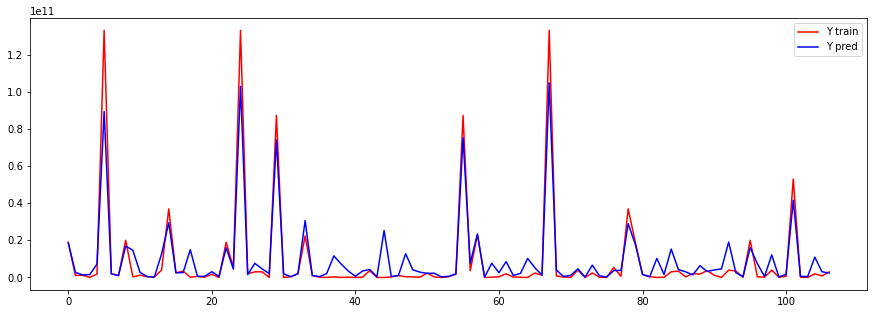

In [15]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), train_y_pred, 'b', label='Y pred')
plt.legend()

In [16]:
# Predicted values for x
y_pred_fcst = regressor.predict(XData_fcst)
#y_pred_fcst

In [17]:
# forecast MSE and RMSE
from sklearn import metrics
RF_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',RF_MSE,'RMSE:',RMSE)

MSE: 2.6813231673361062e+20 RMSE: 16374746310.51152


In [18]:
# forecast R^2
from sklearn.metrics import r2_score
fore_RF_r2=r2_score(YData_fcst , y_pred_fcst)
fore_RF_r2

0.5878901277822987

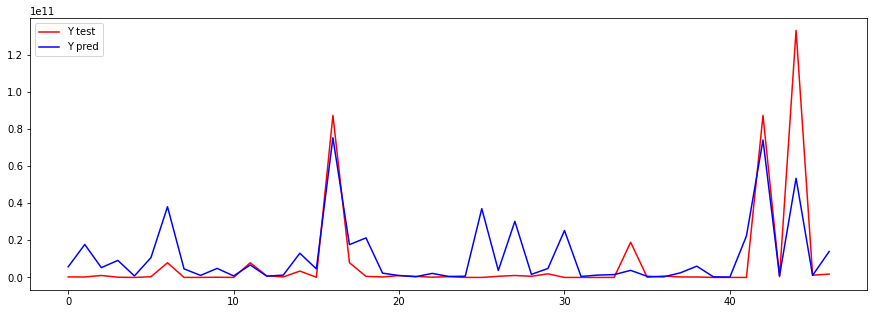

In [19]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

##### Training R^2 is still better than Forecasting  R^2, there may be the problem of overfitting.

### 2.2 Linear Regression(re-assign)

In [20]:
from sklearn.linear_model import LinearRegression  #线性回归
linreg = LinearRegression()
linreg.fit(XData, YData)
train_y_pred = linreg.predict(XData)
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
score 

array([-1.59685989e-01, -9.24911632e-01,  5.72768933e-01, -4.15364971e+00,
       -1.94272787e+03,  7.94051957e-01, -7.14822692e-02,  9.33847932e-02,
       -5.54850079e+00,  1.01114847e-01])

In [21]:
# train R^2
from sklearn.metrics import r2_score
LR_r2=r2_score(YData , train_y_pred)
LR_r2

0.162478468124027

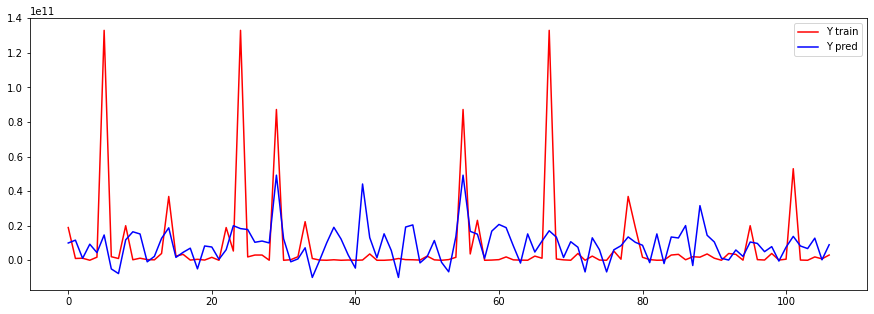

In [22]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), train_y_pred, 'b', label='Y pred')
plt.legend()

In [23]:
# Predicted values for x
y_pred_fcst = linreg.predict(XData_fcst)
#y_pred_fcst

In [24]:
# forecast MSE, RMSE
from sklearn import metrics
LR_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',LR_MSE,'RMSE:',RMSE)

MSE: 4.348119987725811e+20 RMSE: 20852146143.085155


In [25]:
# forecast R^2
from sklearn.metrics import r2_score
fore_LR_r2=r2_score(YData_fcst , y_pred_fcst)
fore_LR_r2

0.33170936112517446

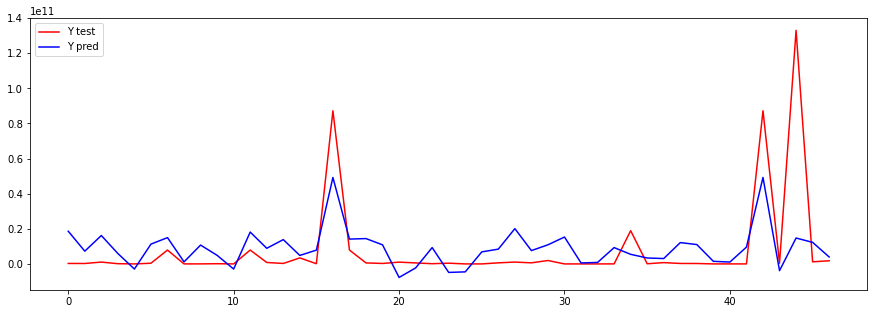

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

### 2.3 Gradient Boosting Regressor

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0, loss='ls')
est.fit(XData,YData)
est_train_pred_y=est.predict(XData)
mean_squared_error(YData,est_train_pred_y)   

4.651824551807274e+19

In [47]:
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')

# train R^2
from sklearn.metrics import r2_score
GB_r2=r2_score(YData , est_train_pred_y)

print(score,GB_r2)

[-1.52913600e-01 -1.00052817e+00  6.93868721e-01 -4.97913331e+00
 -1.69270359e+03  7.79083100e-01 -7.88160626e-02 -1.31670482e-01
 -4.24846007e+00 -3.28328685e-02] 0.9274005984586425


In [48]:
import statistics
statistics.mean(score)

-170.1854988460697

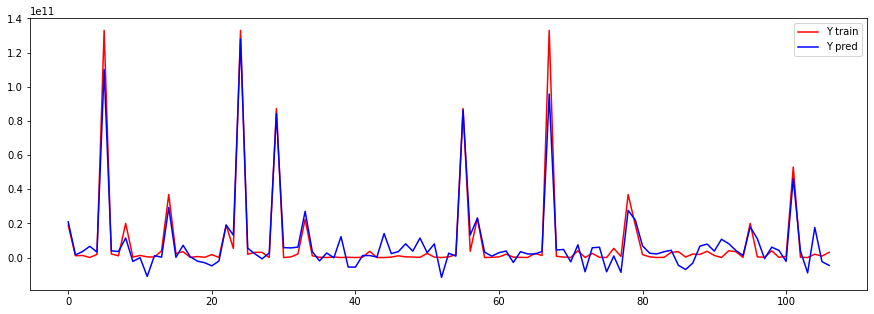

In [49]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), est_train_pred_y, 'b', label='Y pred')
plt.legend()

In [50]:
# Predicted values for x
y_pred_fcst = est.predict(XData_fcst)
#y_pred_fcst

In [51]:
# forecast MSE, RMSE
from sklearn import metrics
GB_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',GB_MSE,'RMSE:',RMSE)

MSE: 4.5388075147753076e+20 RMSE: 21304477263.65354


In [52]:
# forecast R^2
from sklearn.metrics import r2_score
fore_GB_r2=r2_score(YData_fcst , y_pred_fcst)
fore_GB_r2

0.3024013637292653

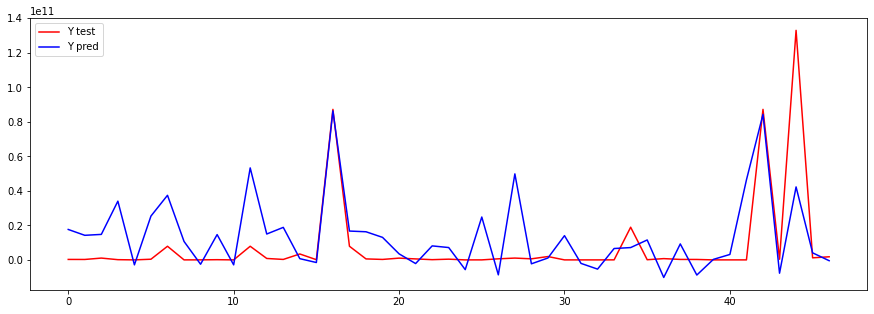

In [53]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

In [45]:
# find the best learning_rate
from sklearn.metrics import r2_score
for i in np.arange(0.1,1.1,0.1): 
    est = GradientBoostingRegressor(n_estimators=100, learning_rate=i,max_depth=1, random_state=0, loss='ls')
    est.fit(XData,YData)
    # val
    score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
    mean_score=statistics.mean(score)
    # train
    est_train_pred_y=est.predict(XData)
    # train R^2
    r2_train=r2_score(YData,est_train_pred_y)
    # forecast
    y_pred_fcst = est.predict(XData_fcst)
    # forecast R^2
    r2_forecast_score=r2_score(YData_fcst , y_pred_fcst)
    print('i:',i,'val_R^2:',mean_score,'train R^2:',r2_train,'test R^2:',r2_forecast_score)
# then, we will choose from sklearn.metrics import r2_score =1.0

i: 0.1 val_R^2: -210.51113653544795 train R^2: 0.5528244629870049 test R^2: 0.4167895027113183
i: 0.2 val_R^2: -195.46480689548792 train R^2: 0.663603826711253 test R^2: 0.4370218647563272
i: 0.30000000000000004 val_R^2: -229.49842115550365 train R^2: 0.7217822092967763 test R^2: 0.4500265542499903
i: 0.4 val_R^2: -170.7454385511914 train R^2: 0.7666670896631561 test R^2: 0.45363365154510105
i: 0.5 val_R^2: -191.46793943601713 train R^2: 0.7975577718828866 test R^2: 0.4613155648008854
i: 0.6 val_R^2: -181.9987761504838 train R^2: 0.8321068206727147 test R^2: 0.45329673124873615
i: 0.7000000000000001 val_R^2: -182.5153113068 train R^2: 0.8658540007165949 test R^2: 0.4085611027609387
i: 0.8 val_R^2: -166.10083017029856 train R^2: 0.8863184871181694 test R^2: 0.37618471997380776
i: 0.9 val_R^2: -173.7121327033378 train R^2: 0.9119656157325297 test R^2: 0.39839051396266534
i: 1.0 val_R^2: -168.65452841450926 train R^2: 0.9274005984586425 test R^2: 0.3024013637292653


### 2.4 AdaBoostRegressor

In [54]:
from sklearn.ensemble import AdaBoostRegressor
adaReg = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=1.0)
adaReg.fit(XData,YData)
ada_train_pred_y=adaReg.predict(XData)

In [55]:
# validation dataset R^2
score=cross_val_score(adaReg, XData, YData, cv=10,scoring='r2')

# train R^2
from sklearn.metrics import r2_score
AB_r2=r2_score(YData , ada_train_pred_y)

print(score,AB_r2)

[-1.32051110e-01  2.27954658e-01  9.85207633e-01 -3.61740539e-01
 -2.61759462e+03  9.39414276e-01 -6.37755879e-02  1.86108804e-01
 -9.81643183e-01  2.85533216e-01] 0.9608494468333841


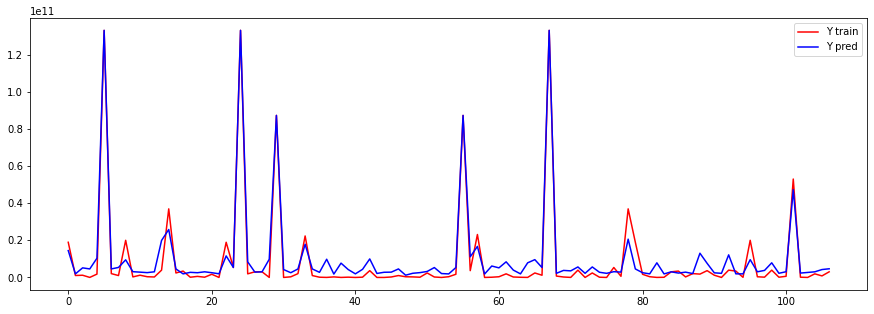

In [56]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), ada_train_pred_y, 'b', label='Y pred')
plt.legend()

In [57]:
# Predicted values for x
y_pred_fcst = adaReg.predict(XData_fcst)
#y_pred_fcst

In [58]:
# forecast MSE, RMSE
from sklearn import metrics
AB_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',AB_MSE,'RMSE:',RMSE)

MSE: 1.4533867080311669e+20 RMSE: 12055648916.716042


In [59]:
# forecast R^2
from sklearn.metrics import r2_score
fore_AB_r2=r2_score(YData_fcst , y_pred_fcst)
fore_AB_r2

0.776619611605903

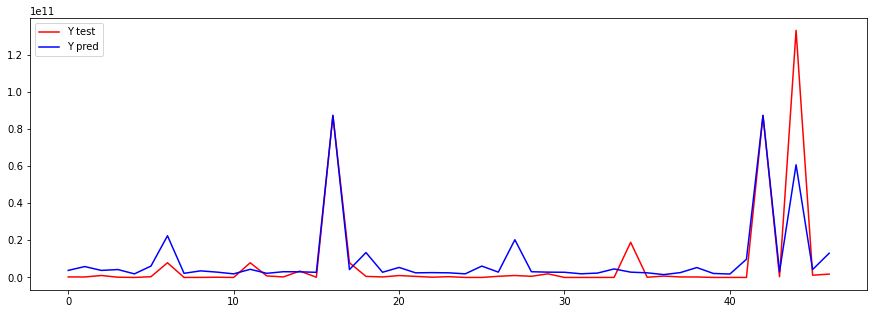

In [60]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

In [42]:
# find the best learning_rate
from sklearn.metrics import r2_score
for i in np.arange(0.1,1.1,0.1): 
    adaReg = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=i)
    adaReg.fit(XData,YData)
    # train
    ada_train_pred_y=adaReg.predict(XData)
    # train R^2
    r2_train=r2_score(YData,ada_train_pred_y)
    # forecast
    y_pred_fcst = adaReg.predict(XData_fcst)
    # forecast R^2
    r2_forecast_score=r2_score(YData_fcst , y_pred_fcst)
    print('i:',i,'train R^2:',r2_train,'test R^2:',r2_forecast_score)
# then, we will choose from sklearn.metrics import r2_score =1.0

i: 0.1 train R^2: 0.9505880004339715 test R^2: 0.8687288443361411
i: 0.2 train R^2: 0.9456445445060443 test R^2: 0.5921924053348047
i: 0.30000000000000004 train R^2: 0.9555716261265679 test R^2: 0.9180391973326241
i: 0.4 train R^2: 0.9465231749766914 test R^2: 0.628884789437713
i: 0.5 train R^2: 0.9463836693118536 test R^2: 0.8608581327480207
i: 0.6 train R^2: 0.942612358745836 test R^2: 0.5758420245267378
i: 0.7000000000000001 train R^2: 0.9407988617480701 test R^2: 0.5552231500269746
i: 0.8 train R^2: 0.9427347722064763 test R^2: 0.8465552422191599
i: 0.9 train R^2: 0.9493179347663586 test R^2: 0.9285929294360087
i: 1.0 train R^2: 0.9608494468333841 test R^2: 0.776619611605903


### Part 3: Weighted Avg

In [61]:
# simply weighted avg these methods predicted values
# RF regressor
RF_y_pred_fcst = regressor.predict(XData_fcst)
# linear reg
LR_y_pred_fcst = linreg.predict(XData_fcst)
# GDBT
GD_y_pred_fcst = est.predict(XData_fcst)
# ada reg
ada_y_pred_fcst = adaReg.predict(XData_fcst)
n=XData_fcst.shape[0]
weights=[0.2,0.1,0.2,0.5]
y_pred_fcst=[]
for i in range(n):
    y_pred_fcst.append(weights[0]*RF_y_pred_fcst[i]+weights[1]*LR_y_pred_fcst[i]+weights[2]*GD_y_pred_fcst[i]+weights[3]*ada_y_pred_fcst[i])

In [62]:
y_pred_fcst2 = pd.Series(y_pred_fcst)

In [63]:
# forecast MSE, RMSE
from sklearn import metrics
avg_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst2)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst2))
print('MSE:',avg_MSE,'RMSE:',RMSE)

MSE: 2.132566571478377e+20 RMSE: 14603309801.131992


In [64]:
# forecast R^2
from sklearn.metrics import r2_score
fore_avg_r2=r2_score(YData_fcst , y_pred_fcst2)
fore_avg_r2

0.6722320725924155

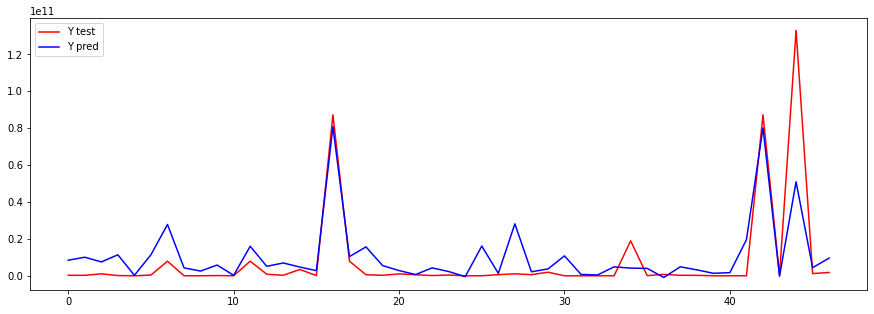

In [65]:
# forecast
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

### Part 4: Results

In [68]:
from pandas import Series,DataFrame
import pandas as pd
results={ 'Method Name':['RandomForestRegressor','Linear Regrssion','Gradient Boosting Regressor','Ada Boost Regressor','Weigted Avg'],
         'train_R^2':[RF_r2,LR_r2,GB_r2,AB_r2,'null'],
         'forecast_R^2':[fore_RF_r2,fore_LR_r2,fore_GB_r2,fore_AB_r2,fore_avg_r2],
         'forecasr_MSE':[RF_MSE,LR_MSE,GB_MSE,AB_MSE,avg_MSE],
}
resultsdf = DataFrame(results)
resultsdf

,Method Name,train_R^2,forecast_R^2,forecasr_MSE
0,RandomForestRegressor,0.899027,0.587890,2.681323e+20
1,Linear Regrssion,0.162478,0.331709,4.348120e+20
2,Gradient Boosting Regressor,0.927401,0.302401,4.538808e+20
3,Ada Boost Regressor,0.960849,0.776620,1.453387e+20
4,Weigted Avg,null,0.672232,2.132567e+20


### note: Since the dataset is small(nrow=154), after splitting as training and testing dataset, there are less rows in testing dataset. Then, the forecast_R^2 and the selection of hyper-paramters will depend on the splitting.
